In [1]:
#Download HSI Data
!wget http://www.ehu.eus/ccwintco/uploads/e/ee/PaviaU.mat http://www.ehu.eus/ccwintco/uploads/5/50/PaviaU_gt.mat

URL transformed to HTTPS due to an HSTS policy
--2023-04-03 20:35:37--  https://www.ehu.eus/ccwintco/uploads/e/ee/PaviaU.mat
Resolving www.ehu.eus (www.ehu.eus)... 158.227.0.65, 2001:720:1410::65
Connecting to www.ehu.eus (www.ehu.eus)|158.227.0.65|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 34806917 (33M)
Saving to: ‘PaviaU.mat.3’

PaviaU.mat.3        100%[===================>]  33.19M  3.94MB/s    in 14s     

2023-04-03 20:35:52 (2.30 MB/s) - ‘PaviaU.mat.3’ saved [34806917/34806917]

URL transformed to HTTPS due to an HSTS policy
--2023-04-03 20:35:52--  https://www.ehu.eus/ccwintco/uploads/5/50/PaviaU_gt.mat
Reusing existing connection to www.ehu.eus:443.
HTTP request sent, awaiting response... 200 OK
Length: 11005 (11K)
Saving to: ‘PaviaU_gt.mat.3’

PaviaU_gt.mat.3     100%[===================>]  10.75K  --.-KB/s    in 0s      

2023-04-03 20:35:52 (143 MB/s) - ‘PaviaU_gt.mat.3’ saved [11005/11005]

FINISHED --2023-04-03 20:35:52--
Total wall clock ti

In [2]:
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sn
import numpy as np    

In [3]:
from scipy.io import loadmat
def read_HSI():
  X = loadmat('PaviaU.mat')['paviaU']
  y = loadmat('PaviaU_gt.mat')['paviaU_gt']
  print(f"X shape: {X.shape}\ny shape: {y.shape}")
  return X, y
X, y = read_HSI()

X shape: (610, 340, 103)
y shape: (610, 340)


In [4]:
from tqdm import tqdm
import pandas as pd
def extract_pixels(dataset, ground_truth):
    df = pd.DataFrame()
    for i in tqdm(range(dataset.shape[2])):
        df = pd.concat([df, pd.DataFrame(dataset[:, :, i].ravel())], axis=1)
    df = pd.concat([df, pd.DataFrame(ground_truth.ravel())], axis=1)
    df.columns = [f'band-{i}' for i in range(1, 1+dataset.shape[2])]+['class']
    return df

In [5]:
df = extract_pixels(X,y)
df.head()

100%|██████████| 103/103 [00:00<00:00, 139.38it/s]


,band-1,band-2,band-3,band-4,band-5,band-6,band-7,band-8,band-9,band-10,...,band-95,band-96,band-97,band-98,band-99,band-100,band-101,band-102,band-103,class
0,647,499,464,371,291,319,365,322,296,305,...,3416,3335,3256,3226,3205,3210,3221,3238,3250,0
1,604,546,527,455,378,377,336,314,324,329,...,2583,2538,2509,2511,2501,2468,2442,2464,2528,0
2,621,746,556,360,285,300,274,276,332,319,...,2288,2242,2193,2202,2225,2266,2308,2345,2361,0
3,637,592,482,556,508,284,178,198,193,224,...,2675,2609,2541,2551,2571,2569,2573,2620,2644,0
4,625,560,480,360,377,341,264,208,231,266,...,2392,2344,2289,2328,2415,2424,2386,2431,2456,0


In [6]:
df.to_csv('X.csv', index=False)

In [7]:
X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values

In [13]:
X.shape  

(207400, 103)

In [14]:
y.shape

(207400,)

In [15]:
from sklearn.decomposition import PCA
kpca = PCA(n_components=50, whiten=True) 
principalComponents = kpca.fit_transform(X)
principalComponents.shape

(207400, 50)

In [16]:
X_train, X_test, y_train, y_test, indices_train, indices_test  = train_test_split(principalComponents, y,  range(X.shape[0]), 
                                                                                  test_size = 0.15, random_state = 11)

In [17]:
X_train.shape, X_test.shape

((176290, 50), (31110, 50))

In [18]:
svm = SVC(kernel='rbf', degree = 11, gamma='scale', cache_size=1024*7)
svm.fit(X_train, y_train)

SVC(cache_size=7168, degree=11)

In [19]:
y_pred = svm.predict(X_test)

In [20]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
print(f'Accuracy: {accuracy_score(y_test, y_pred)*100}%')

Accuracy: 83.03439408550305%


In [21]:
print('Classification report:\n',classification_report(y_test,y_pred,zero_division=0))

Classification report:
               precision    recall  f1-score   support

           0       0.84      0.98      0.90     24700
           1       0.00      0.00      0.00       973
           2       0.75      0.52      0.61      2759
           3       1.00      0.00      0.01       335
           4       0.77      0.07      0.12       458
           5       0.80      0.90      0.84       216
           6       0.00      0.00      0.00       750
           7       0.00      0.00      0.00       205
           8       0.00      0.00      0.00       576
           9       0.00      0.00      0.00       138

    accuracy                           0.83     31110
   macro avg       0.42      0.25      0.25     31110
weighted avg       0.76      0.83      0.78     31110



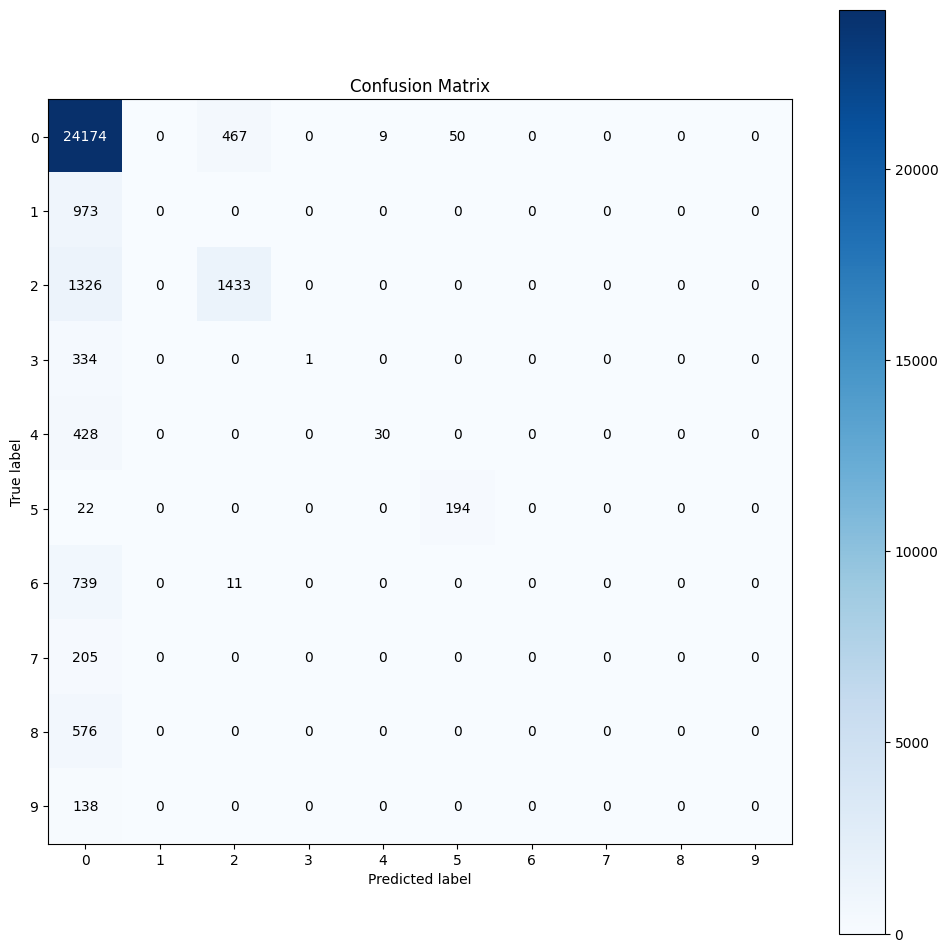

In [22]:
! pip install -q scikit-plot
import scikitplot as skplt
skplt.metrics.plot_confusion_matrix(
    y_test, 
    y_pred,
    figsize=(12,12));

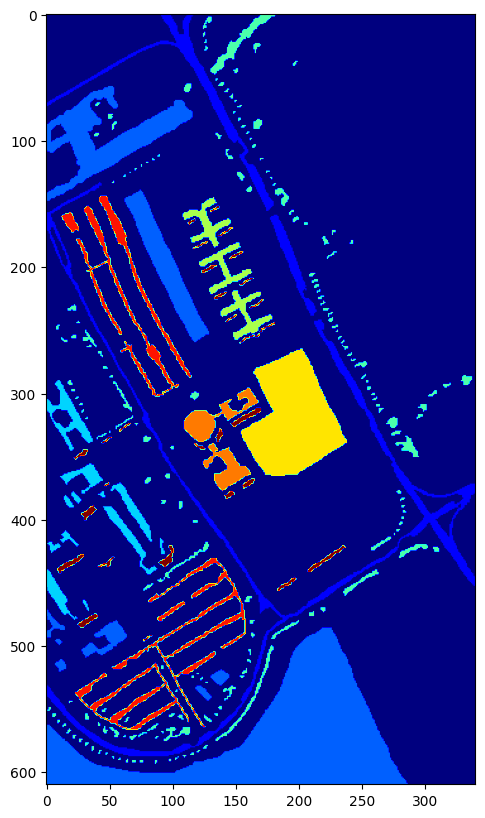

In [49]:
plt.figure(figsize=(12, 10))
plt.imshow(df.iloc[:, -1].values.reshape((610, 340)),cmap='jet')
plt.show()

In [37]:
# !pip install tqdm
from tqdm import tqdm
pre = y_pred
clmap = [0]*X.shape[0]
for i in tqdm(range(len(indices_train))):
    clmap[indices_train[i]] = y[indices_train[i]]
for i in tqdm(range(len(indices_test))):
    clmap[indices_test[i]] = pre[i]

100%|██████████| 31110/31110 [00:00<00:00, 693164.75it/s]


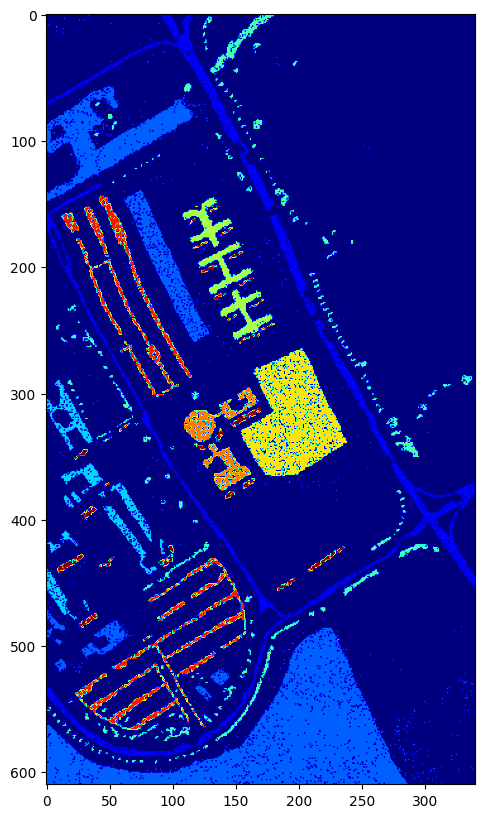

In [48]:
plt.figure(figsize=(12, 10))
plt.imshow(np.array(clmap).reshape((610, 340)),cmap='jet')
plt.show() 